## Introduction

## Data preparation

In [203]:
# !pip install workalendar
# !pip install openpyxl

import pandas as pd
import matplotlib.pyplot as plt
from workalendar.europe import Poland

from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error

### Loading the dataset

In [204]:
file_path = 'Car_accidents_Poland.xlsx'
df = pd.read_excel(file_path, engine='openpyxl')
df['Date'] = pd.to_datetime(df['Date'],format='%d.%m.%Y')
df.set_index('Date', inplace=True)
df = df.sort_index()
df.index.freq = 'D'
df

,Interventions,Arrested_red-handed,Detained_wanted,Drivers_under_the_influence_of_alcohol,Road_accidents,Killed_in_accidents,Injured_in_accidents
Date,,,,,,,
2022-06-15,18116,658,345,277,87,5,95
2022-06-16,15026,677,219,388,65,7,71
2022-06-17,18299,708,345,398,76,10,83
2022-06-18,18769,708,258,404,71,6,72
2022-06-19,16747,739,197,440,59,3,68
...,...,...,...,...,...,...,...
2024-06-14,17103,556,424,237,68,5,73
2024-06-15,17654,599,224,353,56,2,64
2024-06-16,15286,528,237,319,51,5,55


### Adding the exogenous data

In [205]:
df['Day_of_Week'] = df.index.day_name()
day_of_week_columns = pd.get_dummies(df['Day_of_Week'], dtype=float)
df = df.merge(day_of_week_columns, left_index=True, right_index=True)
# Initializing the Poland calendar, adding is_weekend column, is_holiday
cal = Poland()
df['is_holiday'] = df.index.to_series().apply(lambda x: cal.is_holiday(x)).astype(int)

df.tail()

,Interventions,Arrested_red-handed,Detained_wanted,Drivers_under_the_influence_of_alcohol,Road_accidents,Killed_in_accidents,Injured_in_accidents,Day_of_Week,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,is_holiday
Date,,,,,,,,,,,,,,,,
2024-06-14,17103,556,424,237,68,5,73,Friday,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2024-06-15,17654,599,224,353,56,2,64,Saturday,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
2024-06-16,15286,528,237,319,51,5,55,Sunday,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
2024-06-17,16625,592,420,277,88,3,96,Monday,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
2024-06-18,16698,500,450,225,85,3,90,Tuesday,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0


In [206]:
cal = Poland()
cal.holidays(2022)

[(datetime.date(2022, 1, 1), 'New year'),
 (datetime.date(2022, 1, 6), 'Trzech Kroli'),
 (datetime.date(2022, 4, 17), 'Easter Sunday'),
 (datetime.date(2022, 4, 18), 'Easter Monday'),
 (datetime.date(2022, 5, 1), 'Labour Day'),
 (datetime.date(2022, 5, 3), 'Constitution Day'),
 (datetime.date(2022, 6, 5), 'Pentecost Sunday'),
 (datetime.date(2022, 6, 16), 'Corpus Christi'),
 (datetime.date(2022, 8, 15), 'Assumption of Mary to Heaven'),
 (datetime.date(2022, 11, 1), 'All Saints Day'),
 (datetime.date(2022, 11, 11), 'Independence Day'),
 (datetime.date(2022, 12, 25), 'Christmas Day'),
 (datetime.date(2022, 12, 26), 'Boxing Day')]

## Analysis for all Interventions

### Data visualization

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


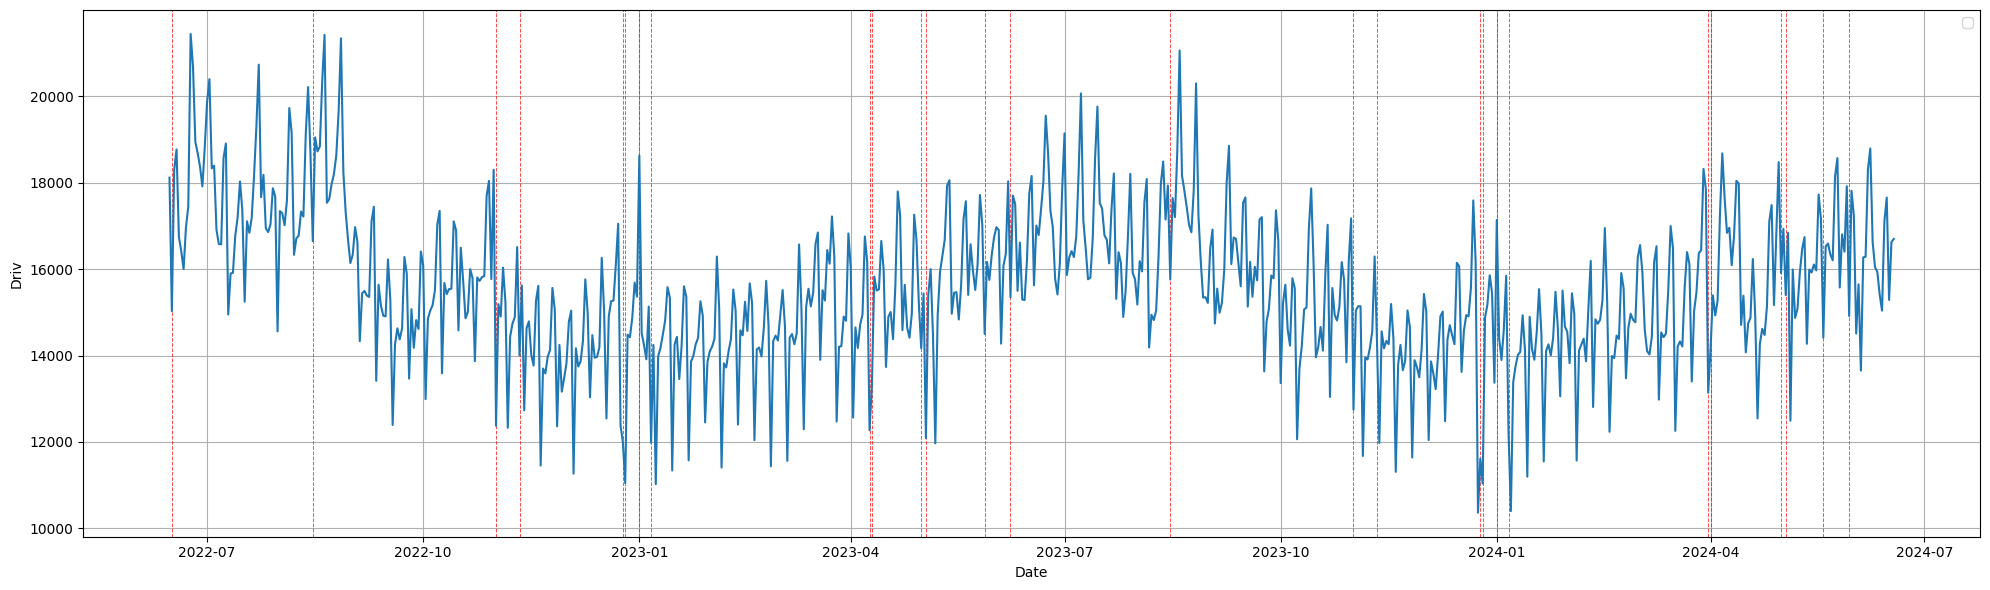

In [207]:
plt.figure(figsize=(20, 6)) 

holidays = df.index[df['is_holiday'] == True]
for holiday in holidays:
    plt.axvline(x=holiday, color='red', linestyle='--', linewidth=0.7, alpha=0.7)

plt.plot(df.index, df["Interventions"])
plt.xlabel('Date')
plt.ylabel('Driv')
plt.title('')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

In [208]:
# fig, axes = plt.subplots(nrows=len(columns), ncols=1, figsize=(10, 20), sharex=True)
# holidays = df.index[df['is_holiday'] == True]
# weekends = df.index[df['is_weekend'] == True]

# for i, col in enumerate(columns):
#     df[col].plot(ax=axes[i], title=col.strip(), legend=False)
#     axes[i].set_ylabel(col.strip())
    
#     # Plot vertical lines on holidays
#     for holiday in holidays:
#         axes[i].axvline(x=holiday, color='r', linestyle='--', lw=1)
      
#     for weekend in weekends:
#         axes[i].axvline(x=weekend, color='g', linestyle='--', lw=1)

# plt.tight_layout()
# plt.show()

### Autoarima analysis

In [209]:
train = df.iloc[:-48]
test  = df.iloc[-48:]
len(train)

start=len(train)
end=start+len(test)-1
len(train)

687

In [210]:
model_all_interventions = auto_arima(
    df["Interventions"],
    exogenous = df[["is_holiday", 'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']],
    start_p=0,
    start_q=0,
    max_p=5,
    max_q =5,
    seasonal=True,
    m=7,
    trace = True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,
    n_jobs=-1
)
model_all_interventions.summary()

C:\Users\Adam\AppData\Roaming\Python\Python312\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=1.81 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=12940.170, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=12466.425, Time=0.73 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=12592.692, Time=0.88 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=12938.171, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=12865.184, Time=0.09 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=12375.514, Time=1.68 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=12434.549, Time=3.89 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=12239.088, Time=2.59 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=12641.827, Time=0.97 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=12440.422, Time=4.69 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=12549.453, Time=1.91 sec
 ARIMA(1,1,0)(2,0,2)[7] intercept   : AIC=inf, Time=5.38 sec
 ARIMA(2,1,0)(1,0,1)[7] intercept   : AIC=12230.017, Time=3.36 sec
 ARIMA(2,1,0)(0,0,1)[7] interce

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  735
Model:             SARIMAX(2, 1, 0)x(1, 0, [1], 7)   Log Likelihood               -6109.009
Date:                             Wed, 19 Jun 2024   AIC                          12230.017
Time:                                     19:32:40   BIC                          12257.608
Sample:                                 06-15-2022   HQIC                         12240.659
                                      - 06-18-2024                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.4634      3.279     -0.751      0.452      -8.890       3.963
ar.L1         -0.3815      0.028    -13.544      0.000      -0.437      -0.326
ar.L2         -0.1039      0.027     -3.877      0.000      -0.156      -0.051
ar.S.L7        0.9841      0.005    197.762      0.000       0.974       0.994
ma.S.L7       -0.8673      0.022    -40.146      0.000      -0.910      -0.825
sigma2      9.575e+05   2.97e+04     32.196      0.000    8.99e+05    1.02e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.69   Jarque-Bera (JB):               545.13
Prob(Q):                              0.41   Prob(JB):                         0.00
Heteroskedasticity (H):               0.77   Skew:                            -0.48
Prob(H) (two-sided):                  0.04   Kurtosis:                         7.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [211]:
model_all_interventions = SARIMAX(train['Interventions'], exog=train[["is_holiday", 'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']], 
                      order=(2,1,0), seasonal_order=(1,0,1,7)).fit() #Best model:  ARIMA(2,1,0)(1,0,1)[7] intercept
model_all_interventions.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                       Interventions   No. Observations:                  687
Model:             SARIMAX(2, 1, 0)x(1, 0, [1], 7)   Log Likelihood               -5622.014
Date:                             Wed, 19 Jun 2024   AIC                          11270.028
Time:                                     19:32:42   BIC                          11328.930
Sample:                                 06-15-2022   HQIC                         11292.818
                                      - 05-01-2024                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
is_holiday -1600.0875     84.085    -19.029      0.000   -1764.891   -1435.284
Friday      1288.3625   7908.032      0.163      0.871   -1.42e+04    1.68e+04
Monday      -159.4593   7910.384     -0.020      0.984   -1.57e+04    1.53e+04
Saturday    1168.4507   7906.313      0.148      0.883   -1.43e+04    1.67e+04
Sunday     -1515.4167   7903.708     -0.192      0.848    -1.7e+04     1.4e+04
Thursday     -70.2673   7902.084     -0.009      0.993   -1.56e+04    1.54e+04
Tuesday     -359.9853   7907.076     -0.046      0.964   -1.59e+04    1.51e+04
Wednesday   -351.6845   7938.682     -0.044      0.965   -1.59e+04    1.52e+04
ar.L1         -0.3034      0.022    -13.773      0.000      -0.347      -0.260
ar.L2         -0.1258      0.033     -3.806      0.000      -0.191      -0.061
ar.S.L7        0.7853      0.092      8.515      0.000       0.605       0.966
ma.S.L7       -0.6733      0.105     -6.436      0.000      -0.878      -0.468
sigma2      7.988e+05   2.44e+04     32.708      0.000    7.51e+05    8.47e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.57   Jarque-Bera (JB):              2705.88
Prob(Q):                              0.45   Prob(JB):                         0.00
Heteroskedasticity (H):               0.68   Skew:                             0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

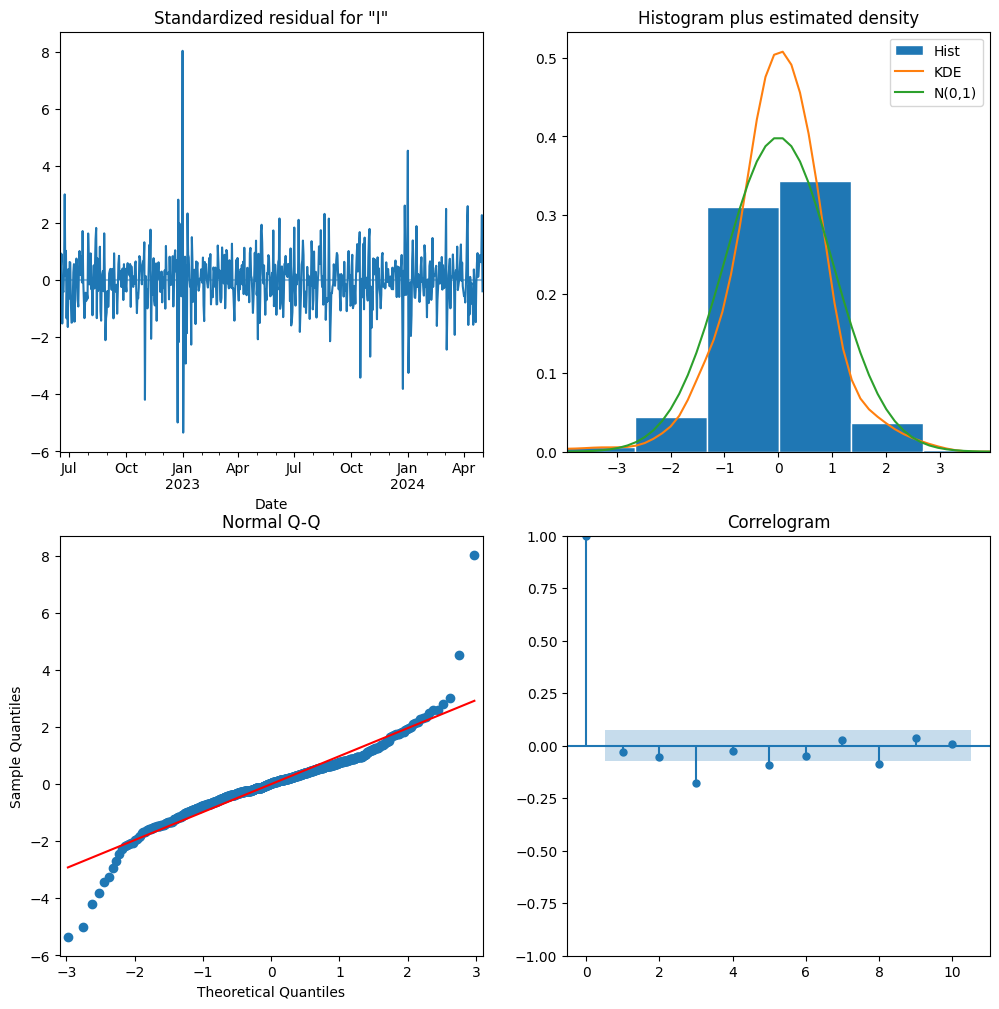

In [212]:
diagnostics = model_all_interventions.plot_diagnostics(figsize=(12, 12))

### Predicting for 4 months

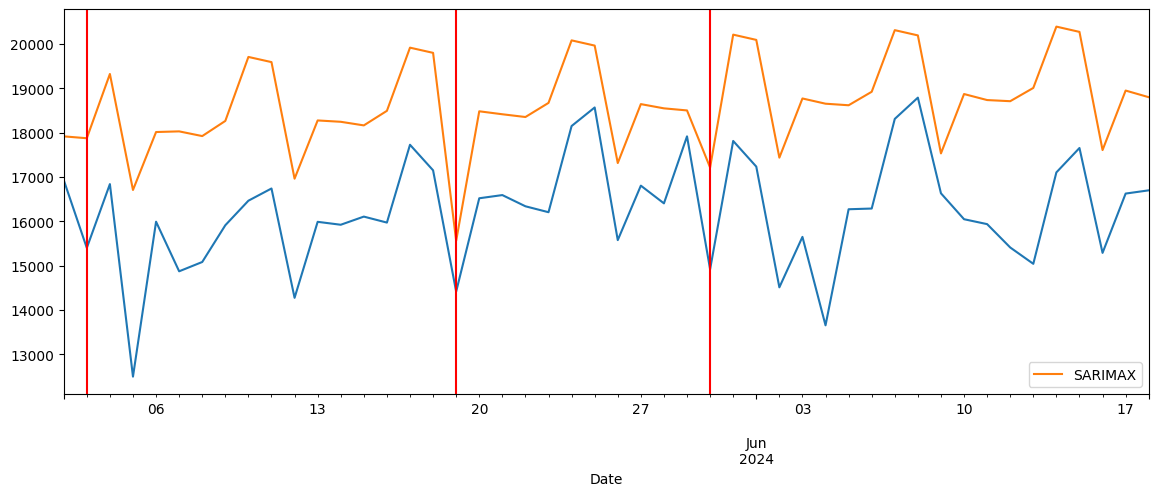

In [213]:
predictions_all_interventions=model_all_interventions.predict(start=start,exog=test[["is_holiday", 'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']],end=end,dynamic=False).rename('SARIMAX')
ax=test['Interventions'].plot(figsize=(14,5))
predictions_all_interventions.plot(legend=True)
for x in test.query('is_holiday==1').index:
    ax.axvline(x=x,color='r')

In [214]:
mean_absolute_percentage_error(test['Interventions'],predictions_all_interventions)*100

15.200856700447424